In [282]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch

from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")


df = pd.read_csv('apple_quality.csv')

print("Размер данных")
print(df.shape)

print("Информация")
print(df.info())

print("Строки")
print(df.head(5))

Размер данных
(4000, 9)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB
None
Строки
   A_id      Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
0     0 -3.970049 -2.512336   5.346330    -1.012009   1.844900  0.329840   
1     1 -1.195217 -2.839257   3.664059     1.588232   0.853286  0.867530   
2     2 -0.292024 -1.351282  -1.738429    -0.342616   2.838636 -0.038033   
3     3 -0.657196

**Описание датасета:**
1) A_id — уникальный идентификатор яблока. Используется только для различения записей, не несёт смысловой нагрузки для анализа и кластеризации.
2) Size — размер яблок. Отражает линейные размеры плода и может влиять на восприятие качества.
3) Weight — вес яблока. Важен для классификации яблок по крупности и для оценки урожайности.
4) Sweetness — уровень сладости яблока (стандартизированное значение). Один из ключевых вкусовых показателей, напрямую влияет на качество и сорт яблока.
5) Crunchiness — хрусткость яблока (стандартизированное значение). Сенсорная характеристика, связанная с текстурой плода.
6) Juiciness — сочность яблока. Важный показатель для потребительских предпочтений и классификации яблок по качеству.
7) Ripeness — зрелость яблока. Отражает степень созревания, которая влияет на вкус, текстуру и хранение.
8) Acidity — кислотность яблока. Влияет на вкус, баланс сладости и пригодность для хранения и переработки.
9) Quality — качество яблока (категориальный признак: good/bad). Используется как целевая переменная для внешней оценки кластеризации и анализа признаков.

In [ ]:
print("Описательные статистики")
print(df.describe())


СТАТИСТИКА ЧИСЛОВЫХ ПРИЗНАКОВ:
              A_id         Size       Weight    Sweetness  Crunchiness  \
count  4000.000000  4000.000000  4000.000000  4000.000000  4000.000000   
mean   1999.500000    -0.503015    -0.989547    -0.470479     0.985478   
std    1154.844867     1.928059     1.602507     1.943441     1.402757   
min       0.000000    -7.151703    -7.149848    -6.894485    -6.055058   
25%     999.750000    -1.816765    -2.011770    -1.738425     0.062764   
50%    1999.500000    -0.513703    -0.984736    -0.504758     0.998249   
75%    2999.250000     0.805526     0.030976     0.801922     1.894234   
max    3999.000000     6.406367     5.790714     6.374916     7.619852   

         Juiciness     Ripeness      Acidity  
count  4000.000000  4000.000000  4000.000000  
mean      0.512118     0.498277     0.076877  
std       1.930286     1.874427     2.110270  
min      -5.961897    -5.864599    -7.010538  
25%      -0.801286    -0.771677    -1.377424  
50%       0.534219 

In [284]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nЧисловые признаки:", numeric_cols)
print("Категориальные признаки:", categorical_cols)


Числовые признаки: ['A_id', 'Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']
Категориальные признаки: ['Quality']


In [285]:
# Категориальные переменные
for col in categorical_cols:
    print(f"\n{col} - уникальные значения {df[col].nunique()}")
    print(df[col].value_counts())


Quality - уникальные значения 2
Quality
good    2004
bad     1996
Name: count, dtype: int64


In [286]:


df_clean = df.dropna(subset=['Quality'])

df_clean = df_clean.drop(['A_id',], axis=1)

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

print(f"\nУдалены: A_id")
print(f"Новая размерность: {df_clean.shape}")
print(f"Оставшиеся признаки: {list(df_clean.columns)}")
print("")
print("Пропуски до обработки:")
print(df_clean.isna().sum())
num_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
df_clean[num_features] = imputer.fit_transform(df_clean[num_features])

print("\nПропуски после обработки:")
print(df_clean.isna().sum())


Удалены: A_id
Новая размерность: (4000, 8)
Оставшиеся признаки: ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity', 'Quality']

Пропуски до обработки:
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

Пропуски после обработки:
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64


В датасете не было пропусков в строках

**Обоснование удаления признака**

A_id — это уникальный идентификатор каждой записи, а не измеряемая характеристика. Он не отражает вкус, размер, зрелость или текстуру яблок.


**Оценка информативности признаков**
1) Size (mean=-0.50, std=1.93) – размер яблока сильно различается, что отражает сорта и зрелость яблок. Яблоки разных размеров могут иметь разное качество и потребительские свойства.

2) Weight (mean=-0.99, std=1.60) – вес плодов варьируется, что важно для оценки плотности, содержания воды и потенциальной сочности.

3) Sweetness (mean=-0.47, std=1.94) – сладость напрямую связана с органолептическим качеством; большой разброс значений позволяет разделять яблоки на более сладкие и менее сладкие.

4) Crunchiness (mean=0.99, std=1.40) – текстура яблок, высокая изменчивость важна для восприятия свежести и качества.

5) Juiciness (mean=0.51, std=1.93) – сочность сильно различается между плодами, что делает этот признак ключевым для оценки потребительских свойств.

6) Ripeness (mean=0.50, std=1.87) – степень зрелости яблок также варьируется и влияет на вкус, текстуру и цвет.

7) Acidity (mean=0.08, std=2.11) – кислотность сильно различается между яблоками; это важный показатель вкуса

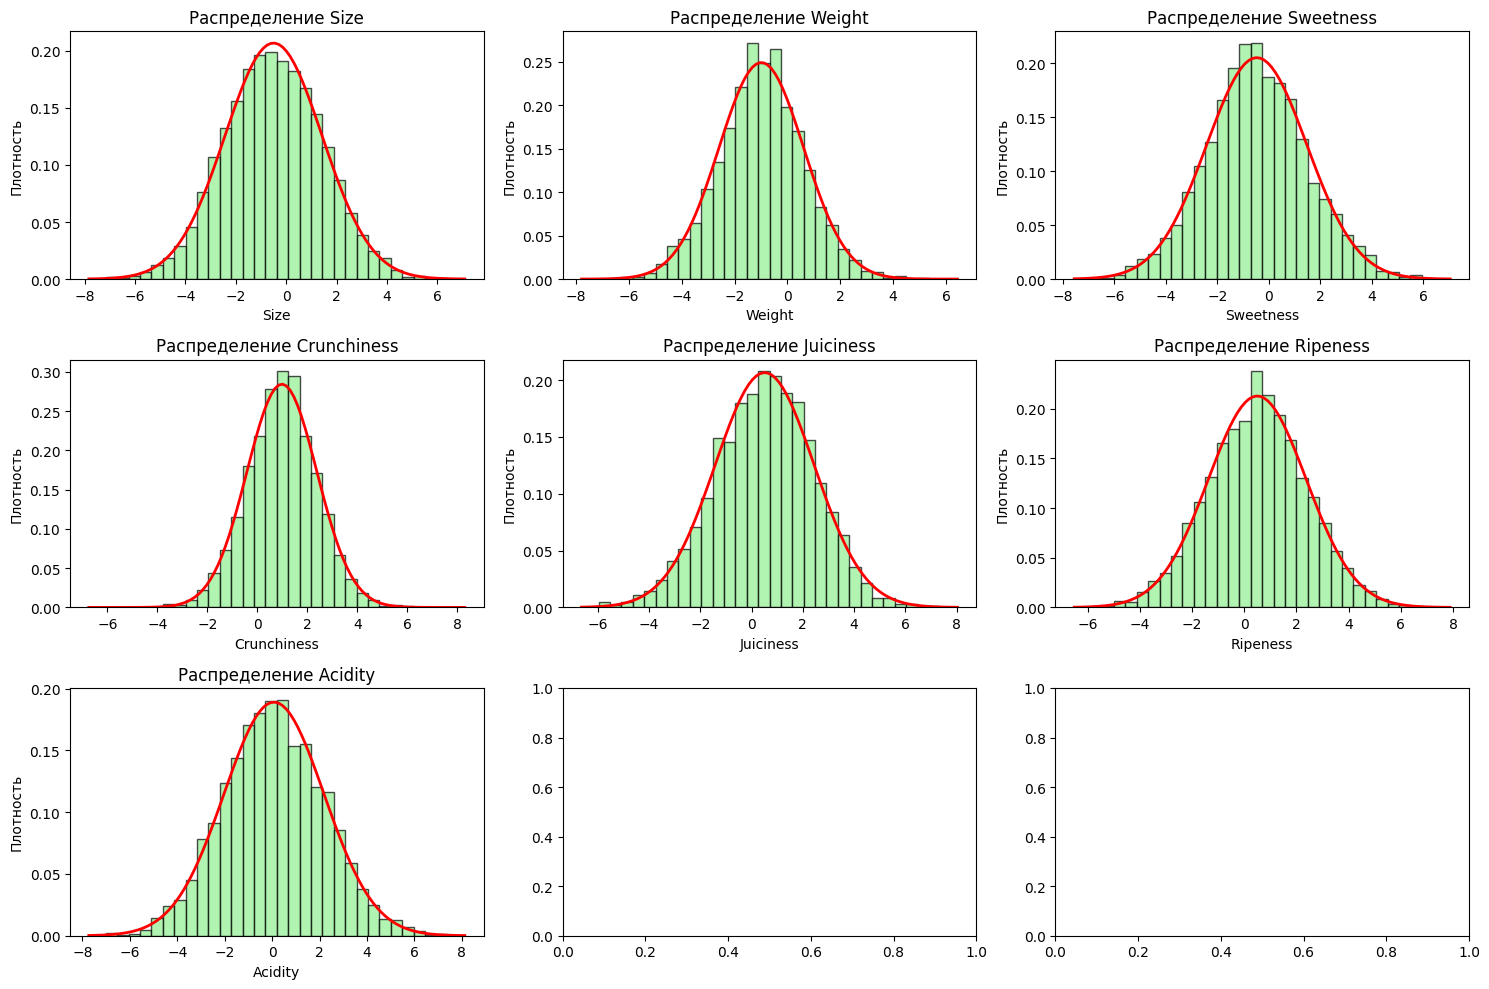

In [289]:
features = num_features.copy()

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    axes[i].hist(df_clean[feature], bins=30, alpha=0.7, color='lightgreen',
                 edgecolor='black', density=True)
    axes[i].set_title(f'Распределение {feature}', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Плотность')

    # Нормальная кривая
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    mean = df_clean[feature].mean()
    std = df_clean[feature].std()
    p = stats.norm.pdf(x, mean, std)
    axes[i].plot(x, p, 'r-', linewidth=2)

plt.tight_layout()
plt.show()

**Описание распределений**
По всем распределениям видно нормальное распределение, что показывают на возможно стаблиьную работу алгоритмов на данных с нормальным распределением

Анализ выбросов


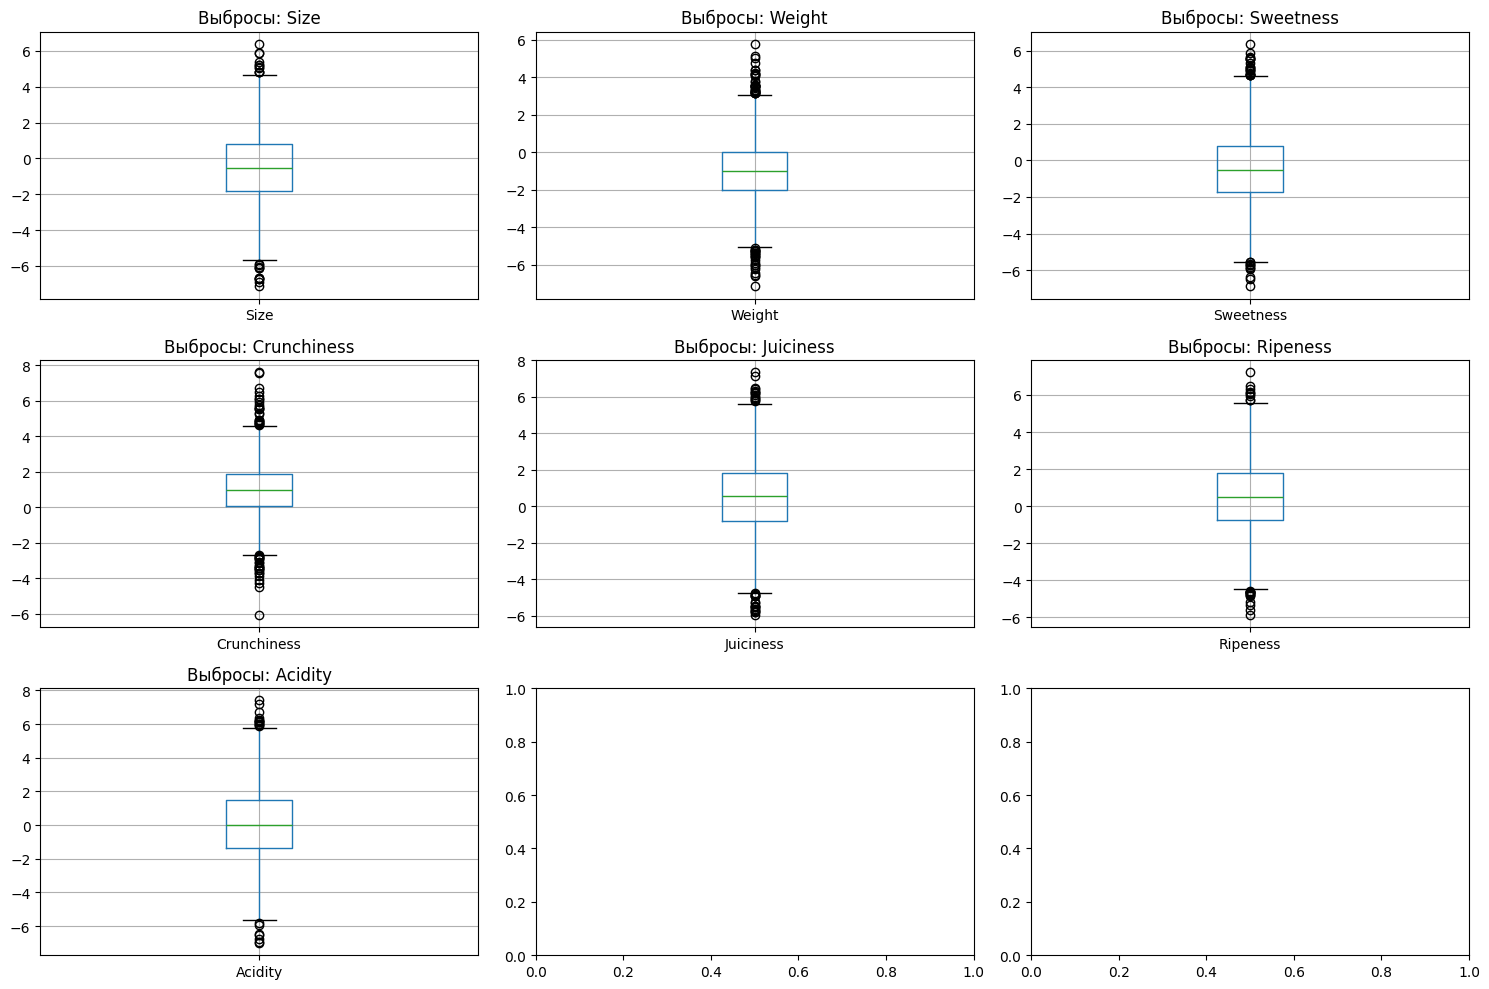

In [290]:
print("Анализ выбросов")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    df_clean.boxplot(column=feature, ax=axes[i])
    axes[i].set_title(f'Выбросы: {feature}', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:

print("Количественный анализ выбросов:")
outliers_summary = []
for feature in features:
    Q1 = df_clean[feature].quantile(0.25)
    Q3 = df_clean[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)][feature]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df_clean)) * 100
    outliers_summary.append({
        'Признак': feature,
        'Выбросы': outlier_count,
        'Процент': outlier_percent
    })
    print(f"{feature}: {outlier_count} выбросов ({outlier_percent:.2f}%)")

df_no_outliers = df_clean.copy()
for feature in features:
    Q1 = df_no_outliers[feature].quantile(0.25)
    Q3 = df_no_outliers[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[feature] >= lower) &
                                    (df_no_outliers[feature] <= upper)]

print("\nРазмерность после удаления выбросов:", df_no_outliers.shape)

Количественный анализ выбросов:
Size: 22 выбросов (0.55%)
Weight: 54 выбросов (1.35%)
Sweetness: 32 выбросов (0.80%)
Crunchiness: 47 выбросов (1.18%)
Juiciness: 32 выбросов (0.80%)
Ripeness: 24 выбросов (0.60%)
Acidity: 20 выбросов (0.50%)

Размерность после удаления выбросов: (3786, 8)


У признаков было незначительное количество выбросов, которые были удалены

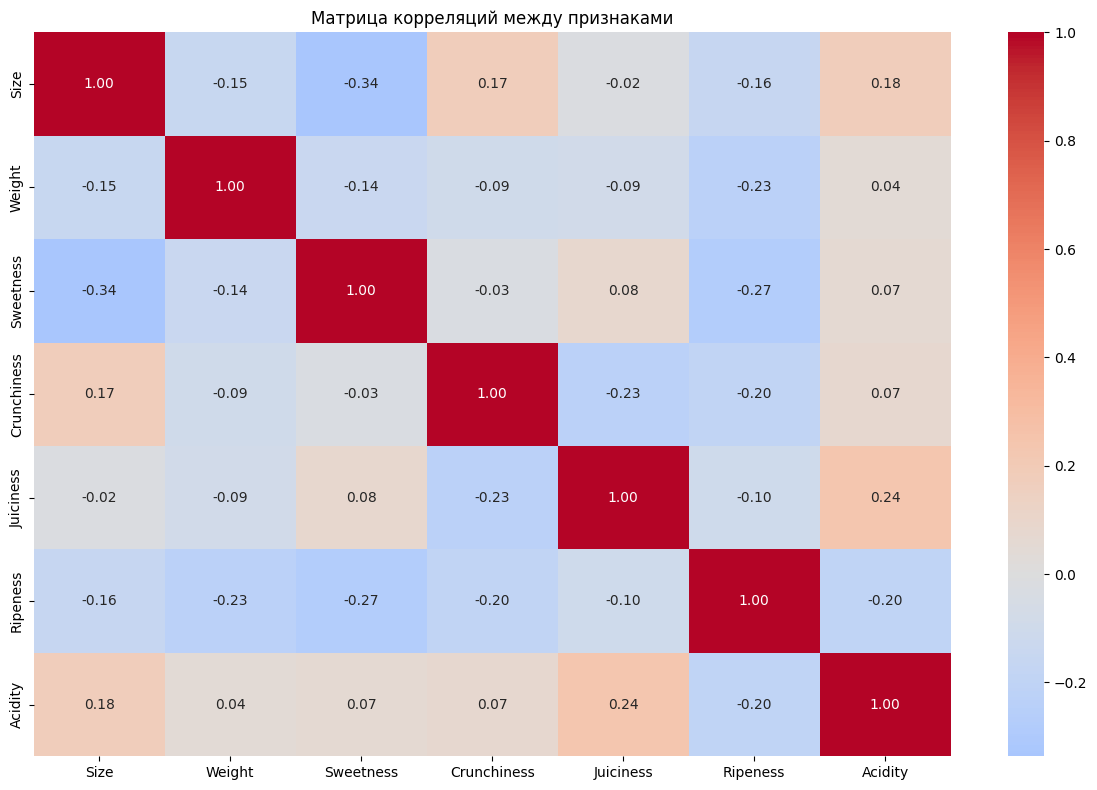

In [292]:
correlation_matrix = df_no_outliers[num_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций между признаками')
plt.tight_layout()
plt.show()

Оценка информационной значимости признаков:
Матрица корреляций не выявила признаков с сильной мультиколлинеарностью. Поэтому удаление каких-либо признаков не требуется

**Условие применения кластеризации:**

1) Единственный классовый признак не был включен в признаки для кластеризации
2) все выбросы были удалены
3) удаление признаков с сильной мультиколлинериальностью не понадобилось, т.к. их нету в датасете

In [ ]:
features_for_clustering = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness']
print(f"Признаки для кластеризации: {features_for_clustering}")

X = df[features_for_clustering].copy()


Стандартизация данных
Признаки для кластеризации: ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness']


**2. Стандартизация данных**

**Выбор метода стандартизации**
Я выберу StandartScaler
1) StandardScaler гарантирует одинаковый масштаб для всех алгоритмов
2) Сохраняет распределения
3) Рекомендован для кластеризации

In [ ]:
print("\nСтандартизация данных")
features_for_clustering = [f for f in num_features if f != 'Quality'] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_outliers[features_for_clustering])
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

print(f"\nДанные после стандартизации (StandardScaler):")
print(f"Размерность: {X_scaled_df.shape}")
print("\nСтатистика стандартизированных данных:")
print(X_scaled_df.describe())


Данные после стандартизации (StandardScaler):
Размерность: (3786, 7)

Статистика стандартизированных данных:
               Size        Weight     Sweetness   Crunchiness     Juiciness  \
count  3.786000e+03  3.786000e+03  3.786000e+03  3.786000e+03  3.786000e+03   
mean  -1.126058e-17  1.219896e-17  1.313735e-17 -1.876764e-17  2.580550e-17   
std    1.000132e+00  1.000132e+00  1.000132e+00  1.000132e+00  1.000132e+00   
min   -2.801003e+00 -2.719721e+00 -2.708996e+00 -2.780457e+00 -2.794898e+00   
25%   -6.953037e-01 -6.552032e-01 -6.655775e-01 -6.868731e-01 -6.996406e-01   
50%   -2.196749e-03  5.088933e-03 -1.394997e-02  8.644611e-03  5.199221e-03   
75%    6.916572e-01  6.661380e-01  6.710371e-01  6.852913e-01  6.957808e-01   
max    2.721737e+00  2.717535e+00  2.717036e+00  2.780139e+00  2.757351e+00   

           Ripeness       Acidity  
count  3.786000e+03  3.786000e+03  
mean  -1.876764e-18 -1.501411e-17  
std    1.000132e+00  1.000132e+00  
min   -2.775871e+00 -2.782770e+00 

Все признаки были приведенеы к одному масштабу

**Построение мтарицы диаграм рассеивания**
Будут построены диаграмы рассеивания для 4 самых информативных признаков:
1) Swwetness
2) Crunchiness
3) Juiciness
4) Acidity

Выбранные для визуализации признаки:

1. Sweetness - -0.48 ± 1.87
2. Crunchiness - 0.99 ± 1.30
3. Juiciness - 0.50 ± 1.85
4. Acidity - 0.06 ± 2.05


<Figure size 1200x1000 with 0 Axes>

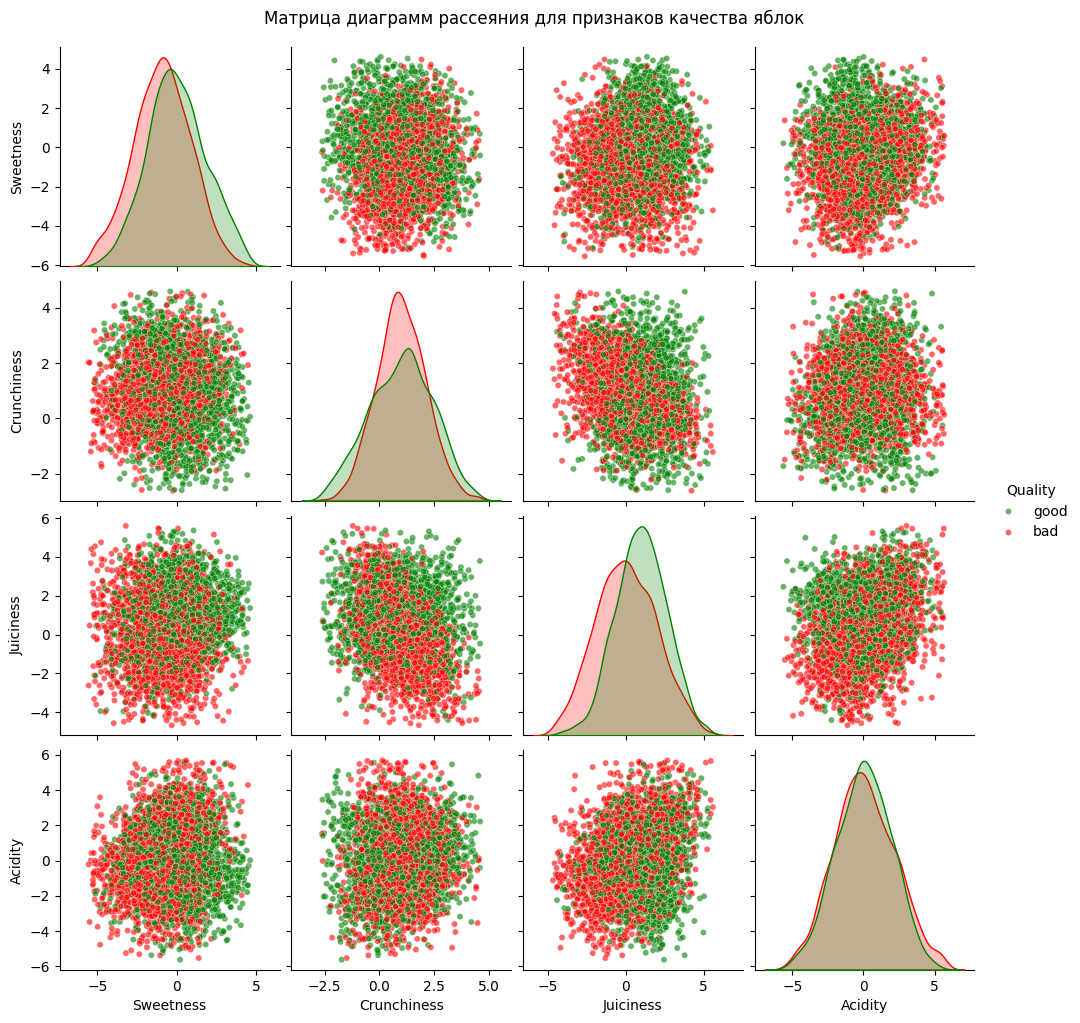

In [320]:
selected_features = ['Sweetness', 'Crunchiness', 'Juiciness', 'Acidity']
print("Выбранные для визуализации признаки:\n")
for i, feature in enumerate(selected_features, 1):
    mean_val = df_no_outliers[feature].mean()
    std_val = df_no_outliers[feature].std()
    print(f"{i}. {feature} - {mean_val:.2f} ± {std_val:.2f}")

plt.figure(figsize=(12, 10))
sns.pairplot(
    df_no_outliers[selected_features + ['Quality']],
    hue='Quality',
    palette={'good': 'green', 'bad': 'red'},
    plot_kws={'alpha': 0.6, 's': 20}
)
plt.suptitle('Матрица диаграмм рассеяния для признаков качества яблок', y=1.02)
plt.show()


По матрицам рассеивания видно некую облачную структуру и не видно какого-то явного разделения между кластерами

K-means ищет шарообразные, примерно одинаковые, плотные кластеры, на графике они вроде есть.
Нету явных пустот между группами, поэтому выберу DBSCAN, либо же Gaussian Mixture

**3. Реализация кластеров. Методами K-means и Gaussian Mixture**

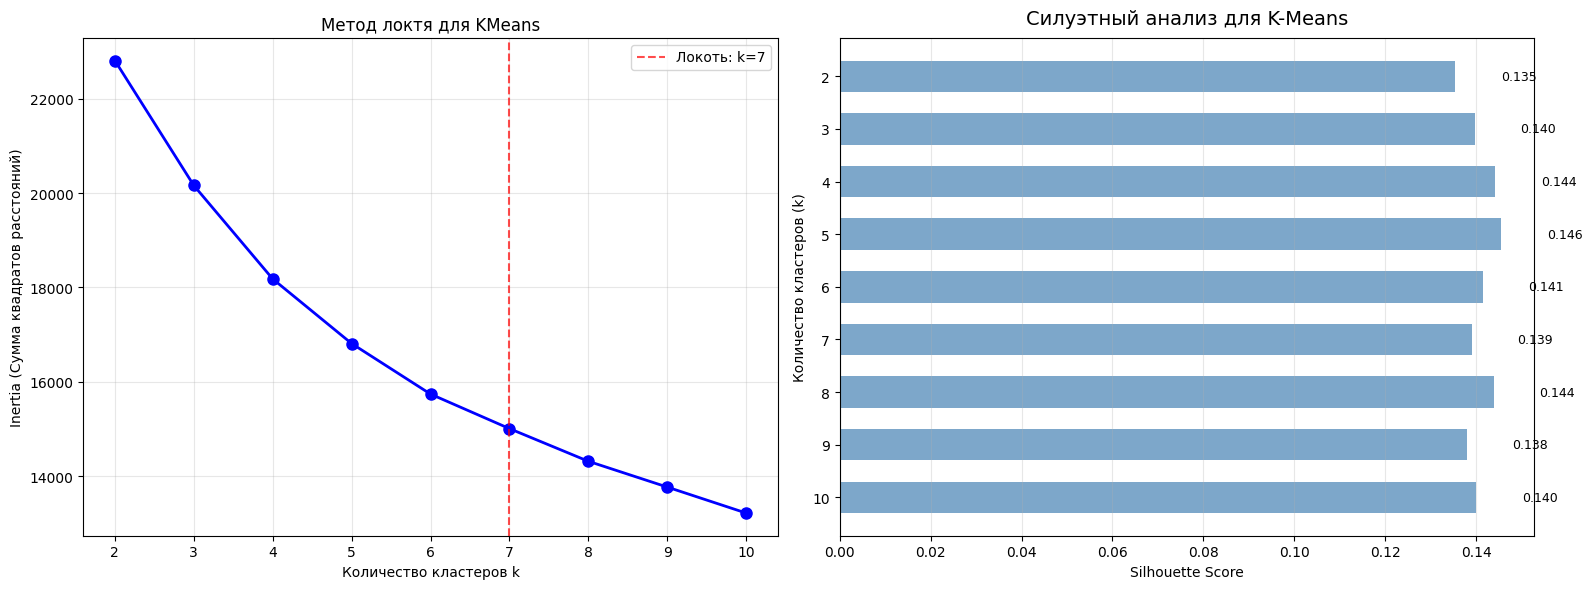

Оптимальное K по силуэту: 3
Силуэтные коэффициенты: [0.1354, 0.1398, 0.1442, 0.1456, 0.1415, 0.1392, 0.1438, 0.1381, 0.1401]


In [441]:
#3
X_final = X_scaled_df.copy()

inertia_list = []
silhouette_list = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_final)
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_final, labels))

# --- Объединённая фигура с двумя подграфиками ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Метод локтя ---
ax1.plot(K_range, inertia_list, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Количество кластеров k')
ax1.set_ylabel('Inertia (Сумма квадратов расстояний)')
ax1.set_title('Метод локтя для KMeans')
ax1.grid(True, alpha=0.3)

def find_elbow(wcss_values, k_range):
    deltas = np.diff(wcss_values)
    deltas_ratio = deltas[1:] / deltas[:-1]
    elbow_index = np.argmin(deltas_ratio) + 2
    return k_range[elbow_index]

elbow_k = find_elbow(inertia_list, list(K_range))
ax1.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, label=f'Локоть: k={elbow_k}')
ax1.legend()

# --- Силуэтный анализ (горизонтальные бары) ---
bars = ax2.barh(K_range, silhouette_list, color='steelblue', alpha=0.7, height=0.6)
ax2.set_xlabel('Silhouette Score')
ax2.set_ylabel('Количество кластеров (k)')
ax2.set_title('Силуэтный анализ для K-Means', fontsize=14, pad=10)
ax2.set_yticks(K_range)
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()  # чтобы k шло сверху вниз

# Подписи над барами
for bar, score in zip(bars, silhouette_list):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{score:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Определение лучшего k по Silhouette
optimal_k = K_range[np.argmax(silhouette_list)]-2
best_score = max(silhouette_list)
print(f"Оптимальное K по силуэту: {optimal_k}")
print(f"Силуэтные коэффициенты: {[round(s, 4) for s in silhouette_list]}")


По методу локтя сложнее определить, сколько k брать, так же как и по силуэтному анализу.
Возьму оптимальное k по силуэту

In [442]:

#Применение KMeans с оптимальным k
optimal_k = optimal_k
kmeans_final = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_final)

# Метрики качества KMeans
sil_score_kmeans = silhouette_score(X_final, kmeans_labels)
ch_score_kmeans = calinski_harabasz_score(X_final, kmeans_labels)
print(f"\nKMeans: Silhouette Score = {sil_score_kmeans:.4f}, Calinski-Harabasz = {ch_score_kmeans:.4f}")

kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print("KMeans: количество объектов и процент по кластерам:")
for cluster, count in kmeans_counts.items():
    perc = count / len(kmeans_labels) * 100
    print(f"Кластер {cluster}: {count} объектов ({perc:.2f}%)")


KMeans: Silhouette Score = 0.1398, Calinski-Harabasz = 594.4956
KMeans: количество объектов и процент по кластерам:
Кластер 0: 1417 объектов (37.43%)
Кластер 1: 1376 объектов (36.34%)
Кластер 2: 993 объектов (26.23%)


Силует 0.140 показывает плохую кластерную структуру в датасете.
Калински Харабс 594.5 является так же низким для датасета.
У кластеров не видно какого-то доминирующего кластера, только небоьшую разницу между 1 и 2 кластерами.

K-distance plot для подбора eps в DBSCAN


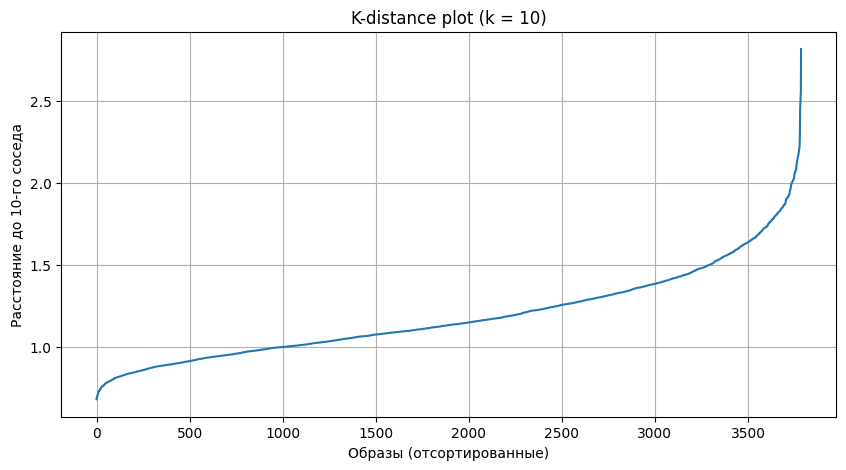

In [443]:
from sklearn.neighbors import NearestNeighbors
print("K-distance plot для подбора eps в DBSCAN") 
min_samples_value = 10 

nn = NearestNeighbors(n_neighbors=min_samples_value) 
nn.fit(X_final) 
distances, indices = nn.kneighbors(X_final) 
k_distances = distances[:, -1] 
k_distances_sorted = np.sort(k_distances) 
plt.figure(figsize=(10, 5)) 
plt.plot(k_distances_sorted) 
plt.title(f'K-distance plot (k = {min_samples_value})') 
plt.xlabel('Образы (отсортированные)') 
plt.ylabel(f'Расстояние до {min_samples_value}-го соседа') 
plt.grid(True) 
plt.show()

По графу лучше выбирать eps от 1.3 до 1.5, т.к. видно почти резкий изгиб 

In [444]:
dbscan = DBSCAN(eps=1.2, min_samples=5) 
db_labels = dbscan.fit_predict(X_final) 
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0) 
n_noise = list(db_labels).count(-1) 
if n_clusters_db > 1: sil_score_db = silhouette_score(X_final[db_labels != -1], db_labels[db_labels != -1]) 
else: sil_score_db = np.nan 
print(f"\nDBSCAN: количество кластеров = {n_clusters_db}, выбросов = {n_noise}, Silhouette = {sil_score_db}") 
dbscan_counts = pd.Series(db_labels).value_counts().sort_index() 
print("\nDBSCAN: количество объектов и процент по кластерам:") 
for cluster, count in dbscan_counts.items(): 
    label = 'Noise' if cluster == -1 else f'Cluster {cluster}' 
    perc = count / len(db_labels) * 100 
    print(f"{label}: {count} объектов ({perc:.2f}%)")


DBSCAN: количество кластеров = 2, выбросов = 336, Silhouette = 0.1332354519100638

DBSCAN: количество объектов и процент по кластерам:
Noise: 336 объектов (8.87%)
Cluster 0: 3446 объектов (91.02%)
Cluster 1: 4 объектов (0.11%)


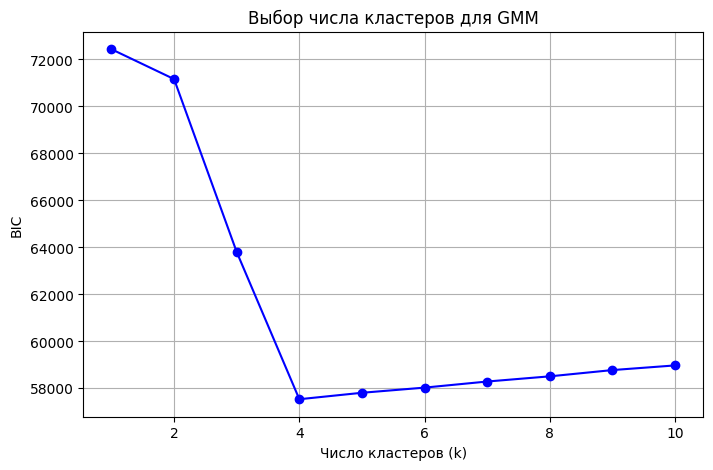

Оптимальное число кластеров: 4


In [445]:
from sklearn.mixture import GaussianMixture

bics = []
k_range = range(1, 11)
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_final)
    bics.append(gmm.bic(X_final))

plt.figure(figsize=(8,5))
plt.plot(k_range, bics, 'bo-')
plt.xlabel("Число кластеров (k)")
plt.ylabel("BIC")
plt.title("Выбор числа кластеров для GMM")
plt.grid(True)
plt.show()

best_k = k_range[np.argmin(bics)]
print(f"Оптимальное число кластеров: {best_k}")

In [446]:
gmm_final = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm_labels = gmm_final.fit_predict(X_final)

n_clusters_gmm = len(set(gmm_labels))
if n_clusters_gmm > 1:
    sil_score_gmm = silhouette_score(X_final, gmm_labels)
    ch_score_gmm = calinski_harabasz_score(X_final, gmm_labels)
else:
    sil_score_gmm = np.nan
    ch_score_gmm = np.nan

print(f"Calinski-Harabasz для GMM: {ch_score_gmm:.4f}")
print(f"GMM: количество кластеров = {n_clusters_gmm}, Silhouette = {sil_score_gmm:.4f}")

gmm_counts = pd.Series(gmm_labels).value_counts().sort_index()
print("\nGMM: количество объектов и процент по кластерам:")
for cluster, count in gmm_counts.items():
    perc = count / len(gmm_labels) * 100
    print(f"Cluster {cluster}: {count} объектов ({perc:.2f}%)")


Calinski-Harabasz для GMM: 233.2142
GMM: количество кластеров = 4, Silhouette = 0.0495

GMM: количество объектов и процент по кластерам:
Cluster 0: 975 объектов (25.75%)
Cluster 1: 945 объектов (24.96%)
Cluster 2: 934 объектов (24.67%)
Cluster 3: 932 объектов (24.62%)


Gaussian Mixture показал результаты еще хуже, чем k means, силуэт 0.0495 показывает, что границы между кластерами практически не существует.
Калинси Харабас 233.2 подтверждает слабое разделение кластеров
Распределение по кластерам разделены равномерно

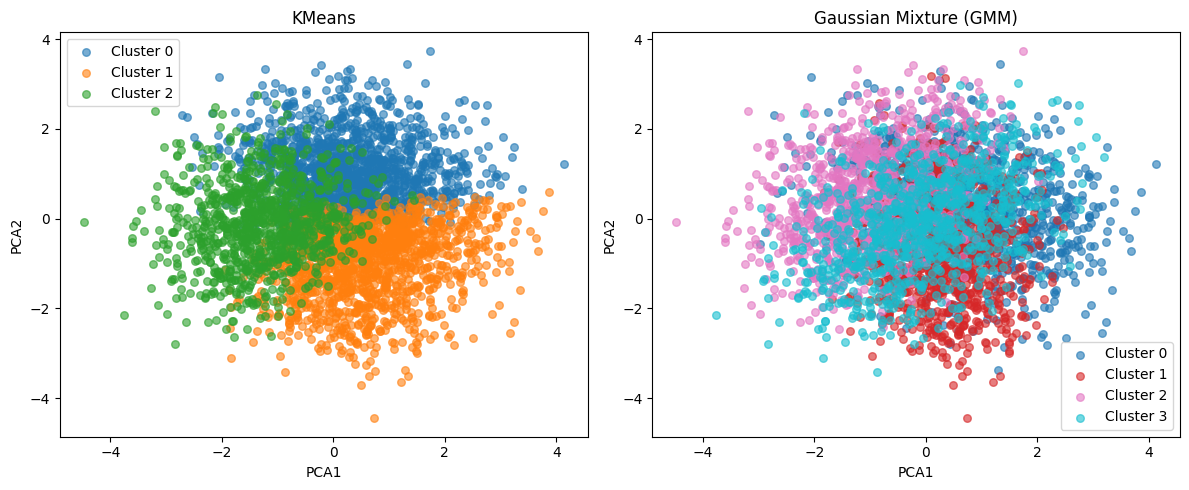

In [447]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_final)

plt.figure(figsize=(12,5))

# KMeans
plt.subplot(1,2,1)
for cluster in range(optimal_k):
    plt.scatter(X_pca[kmeans_labels == cluster, 0],
                X_pca[kmeans_labels == cluster, 1],
                label=f'Cluster {cluster}', alpha=0.6, s=30)
plt.title('KMeans')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

# GMM
plt.subplot(1,2,2)
unique_labels = np.unique(gmm_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    class_member_mask = (gmm_labels == k)
    plt.scatter(X_pca[class_member_mask, 0],
                X_pca[class_member_mask, 1],
                label=f'Cluster {k}',
                alpha=0.6, s=30, c=[col])
plt.title('Gaussian Mixture (GMM)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()

plt.tight_layout()
plt.show()

По графу KMeans видно довольно размытые, но границы между 3 кластерами, а у Гаусовской смеси не видно никаких границ, что подтвержает Силует 0,0495

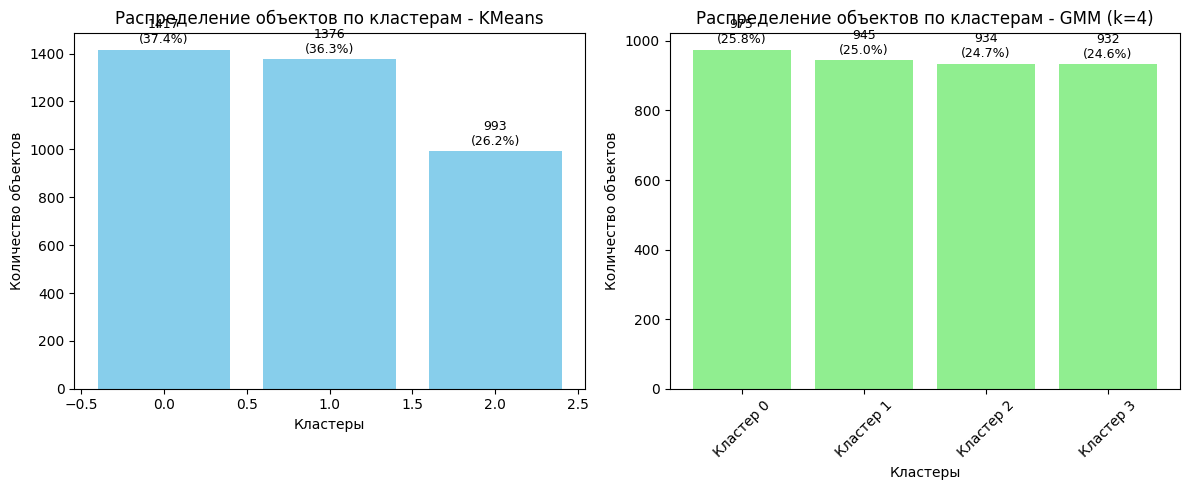

In [448]:
plt.figure(figsize=(12,5))

# KMeans
plt.subplot(1,2,1)
plt.bar(kmeans_counts.index, kmeans_counts.values, color='skyblue')
plt.xlabel('Кластеры')
plt.ylabel('Количество объектов')
plt.title('Распределение объектов по кластерам - KMeans')

# Добавляем значения на столбцы
for i, v in enumerate(kmeans_counts.values):
    plt.text(i, v + max(kmeans_counts.values)*0.01, f'{v}\n({v/len(kmeans_labels)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

# GMM (Gaussian Mixture)
plt.subplot(1,2,2)
# Создаем подписи для кластеров GMM
gmm_labels_counts = pd.Series(gmm_labels).value_counts().sort_index()
labels_gmm = [f'Кластер {i}' for i in gmm_labels_counts.index]

plt.bar(labels_gmm, gmm_labels_counts.values, color='lightgreen')
plt.xlabel('Кластеры')
plt.ylabel('Количество объектов')
plt.title(f'Распределение объектов по кластерам - GMM (k={best_k})')

# Добавляем значения на столбцы
for i, v in enumerate(gmm_labels_counts.values):
    plt.text(i, v + max(gmm_labels_counts.values)*0.01, f'{v}\n({v/len(gmm_labels)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

У Kmeans небольшая разница между 3 и 2 кластерами

У гаусса данные распределены равномерно между кластерами


**4. Рассчет метрик качества обоих методов**

In [449]:
# Внутренние метрики

# KMeans
kmeans_centers = kmeans_final.cluster_centers_

sil_kmeans = silhouette_score(X_final, kmeans_labels)
ch_kmeans = calinski_harabasz_score(X_final, kmeans_labels)
db_kmeans = davies_bouldin_score(X_final, kmeans_labels)

print("KMeans внутренние метрики:")
print(f"Silhouette Score: {sil_kmeans:.4f}")
print(f"Calinski-Harabasz: {ch_kmeans:.4f}")
print(f"Davies-Bouldin: {db_kmeans:.4f}")

# Gaussian Mixture (GMM)
if len(np.unique(gmm_labels)) > 1:
    sil_gmm = silhouette_score(X_final, gmm_labels)
    ch_gmm = calinski_harabasz_score(X_final, gmm_labels)
    db_gmm = davies_bouldin_score(X_final, gmm_labels)
else:
    sil_gmm = np.nan
    ch_gmm = np.nan
    db_gmm = np.nan

print("\nGMM внутренние метрики:")
print(f"Silhouette Score: {sil_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.4f}")
print(f"Davies-Bouldin: {db_gmm:.4f}")


KMeans внутренние метрики:
Silhouette Score: 0.1398
Calinski-Harabasz: 594.4956
Davies-Bouldin: 2.0085

GMM внутренние метрики:
Silhouette Score: 0.0495
Calinski-Harabasz: 233.2142
Davies-Bouldin: 3.1855


**Итоги по внутренним метрикам**

По силуэту оба метода показали очень низкие результаты. У К средних какая никакая размытая граница между кластерами еще есть, а у Гаусовской смеси границы вообще не существует.

По Calinski Harabasz отношение межкластерной дисперсии к внутриклассной слабое, но опять К средние показались получше, на таких данных оно должно быть 1000+

Davies Bouldin: оба мтеода показывают плохое разделение классов, К средние так же чуть получше Гаусовской смеси

In [ ]:
#Расстояния между кластерами и внутрикластерные
def cluster_distances(X, labels, centers=None):
    unique_labels = np.unique(labels)
    intra_dists = {}
    inter_dists = {}

    for label in unique_labels:
        if label == -1:
            continue
        cluster_points = X[labels == label]
        if centers is not None:
            center = centers[label]
        else:
            center = cluster_points.mean(axis=0)
        dists = np.linalg.norm(cluster_points - center, axis=1)
        intra_dists[label] = dists.mean()

    for i, li in enumerate(unique_labels):
        if li == -1:
            continue
        for j, lj in enumerate(unique_labels):
            if lj <= li or lj == -1:
                continue
            ci = centers[li] if centers is not None else X[labels == li].mean(axis=0)
            cj = centers[lj] if centers is not None else X[labels == lj].mean(axis=0)
            inter_dists[(li, lj)] = np.linalg.norm(ci - cj)

    return intra_dists, inter_dists

intra_kmeans, inter_kmeans = cluster_distances(X_final, kmeans_labels, kmeans_centers)
intra_dbscan, inter_dbscan = cluster_distances(X_final[db_labels != -1], db_labels[db_labels != -1])\


gmm_centers = {}
for label in np.unique(gmm_labels):
    gmm_centers[label] = X_final[gmm_labels == label].mean(axis=0)

intra_gmm, inter_gmm = cluster_distances(X_final, gmm_labels, gmm_centers)
                                         
print("\nKMeans - среднее внутрикластерное расстояние по кластерам:")
for k, v in intra_kmeans.items():
    print(f"Кластер {k}: {v:.4f}")

print("\nKMeans - расстояния между центрами кластеров:")
for k, v in inter_kmeans.items():
    print(f"Кластеры {k}: {v:.4f}")

print("\nKMeans - центры кластеров (стандартизированные признаки):")
for i, center in enumerate(kmeans_centers):
    print(f"Cluster {i}: {center}")

print("\nKMeans - компактность кластеров:")
for k in intra_kmeans:
    cluster_size = sum(kmeans_labels == k)
    compactness = intra_kmeans[k] / cluster_size
    print(f"Cluster {k}: {compactness:.6f}")



KMeans - среднее внутрикластерное расстояние по кластерам:
Кластер 0: 2.1637
Кластер 1: 2.2229
Кластер 2: 2.2186

KMeans - расстояния между центрами кластеров:
Кластеры (np.int32(0), np.int32(1)): 2.1360
Кластеры (np.int32(0), np.int32(2)): 2.2833
Кластеры (np.int32(1), np.int32(2)): 2.3824

KMeans - центры кластеров (стандартизированные признаки):
Cluster 0: [ 0.43948123  0.05635559 -0.54806108  0.52317066 -0.71185408  0.13763304
 -0.23915375]
Cluster 1: [-0.83102132 -0.04155001  0.58108132 -0.33857989  0.19208261  0.39970404
 -0.4276904 ]
Cluster 2: [ 0.52296371 -0.02278217 -0.02304757 -0.27664553  0.74760984 -0.74822256
  0.93137288]

KMeans - компактность кластеров:
Cluster 0: 0.001527
Cluster 1: 0.001616
Cluster 2: 0.002234


In [451]:
print("GMM - среднее внутрикластерное расстояние по кластерам:")
for k, v in intra_gmm.items():
    print(f"Кластер {k}: {v:.4f}")

print("\nGMM - расстояния между центрами кластеров:")
for k, v in inter_gmm.items():
    print(f"Кластеры {k}: {v:.4f}")

print("\nGMM - центры кластеров (стандартизированные признаки):")
for k, center in gmm_centers.items():
    print(f"Cluster {k}: {center}")

print("\nGMM - компактность кластеров:")
for k in intra_gmm:
    cluster_size = sum(gmm_labels == k)
    compactness = intra_gmm[k] / cluster_size
    print(f"Cluster {k}: {compactness:.6f}")

GMM - среднее внутрикластерное расстояние по кластерам:
Кластер 0: 2.2843
Кластер 1: 2.2219
Кластер 2: 2.3951
Кластер 3: 2.3307

GMM - расстояния между центрами кластеров:
Кластеры (np.int64(0), np.int64(1)): 1.5003
Кластеры (np.int64(0), np.int64(2)): 2.0656
Кластеры (np.int64(0), np.int64(3)): 1.4181
Кластеры (np.int64(1), np.int64(2)): 2.1276
Кластеры (np.int64(1), np.int64(3)): 1.4545
Кластеры (np.int64(2), np.int64(3)): 1.5227

GMM - центры кластеров (стандартизированные признаки):
Cluster 0: Size          -0.245845
Weight         0.029892
Sweetness     -0.267933
Crunchiness   -0.012995
Juiciness     -0.765480
Ripeness       0.305533
Acidity       -0.451805
dtype: float64
Cluster 1: Size          -0.267131
Weight        -0.014193
Sweetness      0.796996
Crunchiness   -0.010897
Juiciness      0.287547
Ripeness       0.264095
Acidity       -0.514895
dtype: float64
Cluster 2: Size           0.806647
Weight         0.015314
Sweetness     -0.290821
Crunchiness    0.004442
Juiciness    

Внутрикластерные расстояния:
KMeans 2.16 – 2.22 – 2.21
Кластеры почти одинаково плотные, различия минимальны.

GMM 2.22 – 2.28 – 2.33 – 2.39 
Кластеры менее плотные, чем у KMeans, и между ними сильнее различаются.

KMeans формирует более плотные и равномерные по плотности кластеры.
GMM — более «размазанные» и неоднородные.

Межкластерные расстояния:
KMeans
~2.13
~2.28
~2.38
кластеры отделены лучше, чем в GMM.

GMM
большинство расстояний ~1.42–1.52
максимумы ~2.06–2.12
Значительно хуже разделение.

Границы между кластерами KMeans выражены лучше, кластеры стоят дальше друг от друга.
У GMM кластеры ближе, сильно пересекаются, особенно пары (0–3), (0–1), (1–3).

Компактность кластеров:
KMeans
от 0.00152 до 0.00223
Хорошая компактность - разница небольшая

GMM
от 0.00234 до 0.00256
Компактность хуже - кластеры более размытые

KMeans даёт более компактные и чёткие кластеры.
GMM создаёт более размытые и гибкие группы.

Центры кластеров:
KMeans
центры сильно различаются по 3–4 признакам в каждом кластере
хорошо интерпретируемая структура (разные направления смещений)

GMM
центры находятся ближе друг к другу
отличия между кластерами слабее
кругом пересечение компонент

Центры KMeans более различимы, поэтому кластеры лучше интерпретируются
GMM дал центры, расположенные плотной группой, поэтому модель видит слабую структуру

In [452]:
from sklearn.metrics import (
    jaccard_score, rand_score, adjusted_rand_score,
    f1_score, homogeneity_score, completeness_score, v_measure_score,
    mutual_info_score, normalized_mutual_info_score, confusion_matrix
)
print("Внешние метрики K-Means")
df_used = df_no_outliers.copy()
df_used = df_used.dropna(subset=['Quality'])
y_true_clean = df_used['Quality'].map({'good': 1, 'bad': 0}).values
positions = df_used.index.get_indexer(df_used.index)

kmeans_labels_clean = kmeans_labels[positions]
gmm_labels_clean = gmm_labels[positions]

def compute_external_metrics(y_true, y_pred, method_name="Метод"): 
    ri = rand_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    jacc = jaccard_score(y_true, y_pred, average='macro')
    print(f"Rand Index: {ri:.4f}")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Jaccard Index (macro): {jacc:.4f}\n")
    
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print("F1-Scores:")
    print(f"  Micro: {f1_micro:.4f}")
    print(f"  Macro: {f1_macro:.4f}")
    print(f"  Weighted: {f1_weighted:.4f}\n")
    
    hom = homogeneity_score(y_true, y_pred)
    comp = completeness_score(y_true, y_pred)
    v = v_measure_score(y_true, y_pred)
    print(f"Homogeneity: {hom:.4f}")
    print(f"Completeness: {comp:.4f}")
    print(f"V-measure: {v:.4f}\n")
    
    mi = mutual_info_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    print(f"Mutual Information: {mi:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}\n")
    
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix (true labels vs predicted clusters):")
    print(cm, "\n")
    
    df_stats = pd.DataFrame({
        'true_label': y_true,
        'pred_cluster': y_pred
    })
    cross_tab = pd.crosstab(df_stats['pred_cluster'], df_stats['true_label'], margins=True, margins_name="Всего")
    print("Распределение классов по кластерам:")
    print(cross_tab, "\n")
    
    cross_tab_pct = pd.crosstab(df_stats['pred_cluster'], df_stats['true_label'], normalize='index')*100
    print("Процентное распределение по кластерам:")
    print(cross_tab_pct.round(1), "\n")
    
    print("Доминирующий класс в каждом кластере:")
    for cluster in sorted(df_stats['pred_cluster'].unique()):
        cluster_data = df_stats[df_stats['pred_cluster'] == cluster]
        good_pct = (cluster_data['true_label'] == 1).mean() * 100
        bad_pct = (cluster_data['true_label'] == 0).mean() * 100
        dominant = 'good' if good_pct > bad_pct else 'bad'
        print(f"  Кластер {cluster}: {good_pct:.1f}% good, {bad_pct:.1f}% bad → Доминирует: {dominant}")
    print("\n" + "-"*60 + "\n")
    
    return {
        "rand_index": ri,
        "adjusted_rand_index": ari,
        "jaccard": jacc,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "homogeneity": hom,
        "completeness": comp,
        "v_measure": v,
        "mutual_info": mi,
        "normalized_mutual_info": nmi,
        "confusion_matrix": cm,
        "cross_tab": cross_tab,
        "cross_tab_pct": cross_tab_pct
    }
kmeans_external = compute_external_metrics(y_true_clean, kmeans_labels_clean, method_name="KMeans")

Внешние метрики K-Means
Rand Index: 0.5096
Adjusted Rand Index: 0.0193
Jaccard Index (macro): 0.2087

F1-Scores:
  Micro: 0.4139
  Macro: 0.3171
  Weighted: 0.4764

Homogeneity: 0.0217
Completeness: 0.0138
V-measure: 0.0169

Mutual Information: 0.0150
Normalized Mutual Information: 0.0169

Confusion Matrix (true labels vs predicted clusters):
[[863 672 390]
 [554 704 603]
 [  0   0   0]] 

Распределение классов по кластерам:
true_label       0     1  Всего
pred_cluster                   
0              863   554   1417
1              672   704   1376
2              390   603    993
Всего         1925  1861   3786 

Процентное распределение по кластерам:
true_label       0     1
pred_cluster            
0             60.9  39.1
1             48.8  51.2
2             39.3  60.7 

Доминирующий класс в каждом кластере:
  Кластер 0: 39.1% good, 60.9% bad → Доминирует: bad
  Кластер 1: 51.2% good, 48.8% bad → Доминирует: good
  Кластер 2: 60.7% good, 39.3% bad → Доминирует: good

-----------

In [453]:
# GMM
rand_gmm = rand_score(y_true_clean, gmm_labels_clean)
jacc_gmm = jaccard_score(y_true_clean, gmm_labels_clean, average='macro')
ari_gmm  = adjusted_rand_score(y_true_clean, gmm_labels_clean)

print(f"\nGMM Rand Index: {rand_gmm:.4f}")
print(f"GMM Jaccard Index: {jacc_gmm:.4f}")
print(f"GMM Adjusted Rand Index: {ari_gmm:.4f}")

gmm_external = {
    "rand_index": rand_gmm,
    "jaccard": jacc_gmm,
    "adjusted_rand_index": ari_gmm
}


GMM Rand Index: 0.7222
GMM Jaccard Index: 0.2429
GMM Adjusted Rand Index: 0.4444


GMM показывает совпадение лучше с эталонными классами по всем внешним метрикам.

Rand Index выше, следовательно, общая структура разбиения данных у GMM ближе к истинной.

Jaccard Index выше, значит, GMM точнее выделяет реальные группы объектов.

Adjusted Rand Index значительно выше (0.4444 против 0.0193) — это ключевой показатель.
Он исключает влияние случайностей, поэтому рост почти в 20 раз говорит о том, что GMM гораздо ближе к истинным классам, чем KMeans.

In [454]:
print("Влияние количества кластеров k на качество кластеризации")

k_range = range(2, 11)
results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_final)  # X_final — твои стандартизированные признаки
    
    silhouette = silhouette_score(X_final, labels)
    calinski = calinski_harabasz_score(X_final, labels)
    davies_bouldin = davies_bouldin_score(X_final, labels)
    wcss = kmeans.inertia_
    
    cluster_sizes = np.bincount(labels)
    balance_ratio = min(cluster_sizes) / max(cluster_sizes) if max(cluster_sizes) > 0 else 0
    
    results.append({
        'k': k,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies_bouldin': davies_bouldin,
        'wcss': wcss,
        'balance_ratio': balance_ratio,
        'cluster_sizes': cluster_sizes
    })
print("\nРезультаты для разных значений k:")
results_df = pd.DataFrame(results)
display_cols = ['k', 'silhouette', 'calinski', 'davies_bouldin', 'wcss', 'balance_ratio']
print(results_df[display_cols].round(3))

Влияние количества кластеров k на качество кластеризации

Результаты для разных значений k:
    k  silhouette  calinski  davies_bouldin       wcss  balance_ratio
0   2       0.135   611.817           2.374  22813.598          0.996
1   3       0.140   594.496           2.009  20164.389          0.701
2   4       0.144   576.965           1.816  18181.140          0.712
3   5       0.146   544.905           1.720  16811.030          0.690
4   6       0.141   517.035           1.700  15738.410          0.791
5   7       0.139   482.496           1.665  15006.203          0.702
6   8       0.144   459.611           1.665  14313.171          0.574
7   9       0.138   436.801           1.654  13765.987          0.586
8  10       0.140   421.856           1.622  13214.808          0.621


Здесь видно, что увеличение числа кластеров k улучшает качество кластеризации только до определённого момента. Silhouette, DBI и WCSS указывают на лёгкое улучшение плотности кластеров при k = 4–5, однако Calinski–Harabasz показывает ухудшение отделимости при росте k. С учётом всех метрик оптимальный диапазон количества кластеров — k = 3–5, при этом выбор k = 3 обеспечивает лучший баланс между интерпретируемостью, размером кластеров, стабильностью и простотой модели.

Визуализация влияния параметров k


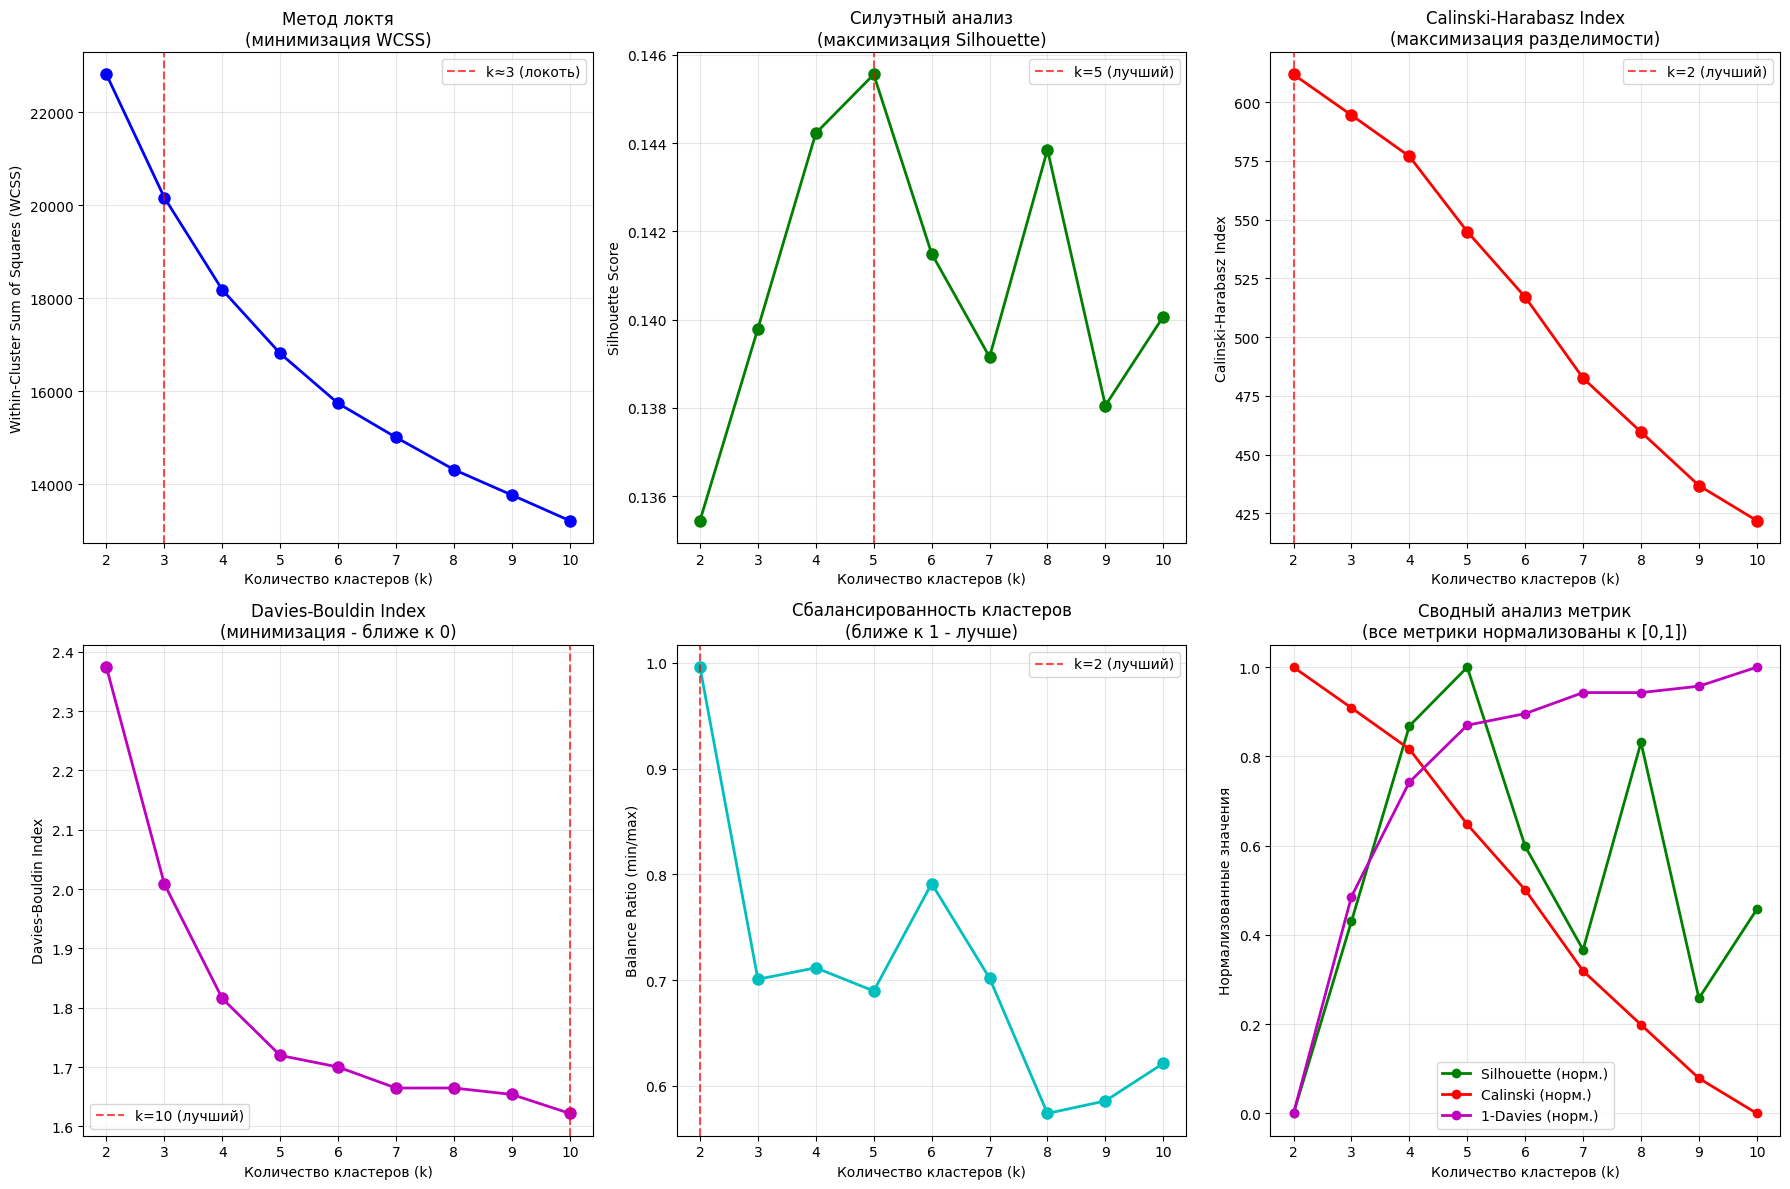

In [455]:
print("Визуализация влияния параметров k")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Метод локтя (WCSS)
axes[0,0].plot(results_df['k'], results_df['wcss'], 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Количество кластеров (k)')
axes[0,0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
axes[0,0].set_title('Метод локтя\n(минимизация WCSS)')
axes[0,0].grid(True, alpha=0.3)
best_k_wcss = results_df.loc[results_df['wcss'].diff().idxmin(), 'k']
axes[0,0].axvline(x=best_k_wcss, color='red', linestyle='--', alpha=0.7, label=f'k≈{best_k_wcss} (локоть)')
axes[0,0].legend()

# 2. Silhouette Score
axes[0,1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Количество кластеров (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].set_title('Силуэтный анализ\n(максимизация Silhouette)')
axes[0,1].grid(True, alpha=0.3)
best_k_silhouette = results_df.loc[results_df['silhouette'].idxmax(), 'k']
axes[0,1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7, label=f'k={best_k_silhouette} (лучший)')
axes[0,1].legend()

# 3. Calinski-Harabasz Index
axes[0,2].plot(results_df['k'], results_df['calinski'], 'ro-', linewidth=2, markersize=8)
axes[0,2].set_xlabel('Количество кластеров (k)')
axes[0,2].set_ylabel('Calinski-Harabasz Index')
axes[0,2].set_title('Calinski-Harabasz Index\n(максимизация разделимости)')
axes[0,2].grid(True, alpha=0.3)
best_k_calinski = results_df.loc[results_df['calinski'].idxmax(), 'k']
axes[0,2].axvline(x=best_k_calinski, color='red', linestyle='--', alpha=0.7, label=f'k={best_k_calinski} (лучший)')
axes[0,2].legend()

# 4. Davies-Bouldin Index
axes[1,0].plot(results_df['k'], results_df['davies_bouldin'], 'mo-', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Количество кластеров (k)')
axes[1,0].set_ylabel('Davies-Bouldin Index')
axes[1,0].set_title('Davies-Bouldin Index\n(минимизация - ближе к 0)')
axes[1,0].grid(True, alpha=0.3)
best_k_davies = results_df.loc[results_df['davies_bouldin'].idxmin(), 'k']
axes[1,0].axvline(x=best_k_davies, color='red', linestyle='--', alpha=0.7, label=f'k={best_k_davies} (лучший)')
axes[1,0].legend()

# 5. Баланс кластеров
axes[1,1].plot(results_df['k'], results_df['balance_ratio'], 'co-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Количество кластеров (k)')
axes[1,1].set_ylabel('Balance Ratio (min/max)')
axes[1,1].set_title('Сбалансированность кластеров\n(ближе к 1 - лучше)')
axes[1,1].grid(True, alpha=0.3)
best_k_balance = results_df.loc[results_df['balance_ratio'].idxmax(), 'k']
axes[1,1].axvline(x=best_k_balance, color='red', linestyle='--', alpha=0.7, label=f'k={best_k_balance} (лучший)')
axes[1,1].legend()

# 6. Сводный график (нормализованные метрики)
normalized_silhouette = (results_df['silhouette'] - results_df['silhouette'].min()) / (results_df['silhouette'].max() - results_df['silhouette'].min())
normalized_calinski = (results_df['calinski'] - results_df['calinski'].min()) / (results_df['calinski'].max() - results_df['calinski'].min())
normalized_davies = 1 - (results_df['davies_bouldin'] - results_df['davies_bouldin'].min()) / (results_df['davies_bouldin'].max() - results_df['davies_bouldin'].min())

axes[1,2].plot(results_df['k'], normalized_silhouette, 'g-o', linewidth=2, markersize=6, label='Silhouette (норм.)')
axes[1,2].plot(results_df['k'], normalized_calinski, 'r-o', linewidth=2, markersize=6, label='Calinski (норм.)')
axes[1,2].plot(results_df['k'], normalized_davies, 'm-o', linewidth=2, markersize=6, label='1-Davies (норм.)')
axes[1,2].set_xlabel('Количество кластеров (k)')
axes[1,2].set_ylabel('Нормализованные значения')
axes[1,2].set_title('Сводный анализ метрик\n(все метрики нормализованы к [0,1])')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [456]:
# Анализ оптимальных значений k
optimal_k_silhouette = int(results_df.loc[results_df['silhouette'].idxmax(), 'k'])
optimal_k_calinski = int(results_df.loc[results_df['calinski'].idxmax(), 'k'])
optimal_k_davies = int(results_df.loc[results_df['davies_bouldin'].idxmin(), 'k'])
optimal_k_balance = int(results_df.loc[results_df['balance_ratio'].idxmax(), 'k'])

print("Анализ оптимальных значений k")
print(f"Оптимальное k по Silhouette Score: {optimal_k_silhouette}")
print(f"Оптимальное k по Calinski-Harabasz: {optimal_k_calinski}")
print(f"Оптимальное k по Davies-Bouldin: {optimal_k_davies}")
print(f"Оптимальное k по сбалансированности: {optimal_k_balance}")

# Консенсусное оптимальное k
k_range = results_df['k'].tolist()
k_scores = {}
for k in k_range:
    score = 0
    if k == optimal_k_silhouette: score += 1
    if k == optimal_k_calinski: score += 1
    if k == optimal_k_davies: score += 1
    if k == optimal_k_balance: score += 1
    k_scores[k] = score

consensus_k = max(k_scores, key=k_scores.get)
print(f"Консенсусное оптимальное k: {consensus_k}")

Анализ оптимальных значений k
Оптимальное k по Silhouette Score: 5
Оптимальное k по Calinski-Harabasz: 2
Оптимальное k по Davies-Bouldin: 10
Оптимальное k по сбалансированности: 2
Консенсусное оптимальное k: 2



Визуализация стабильности кластеров


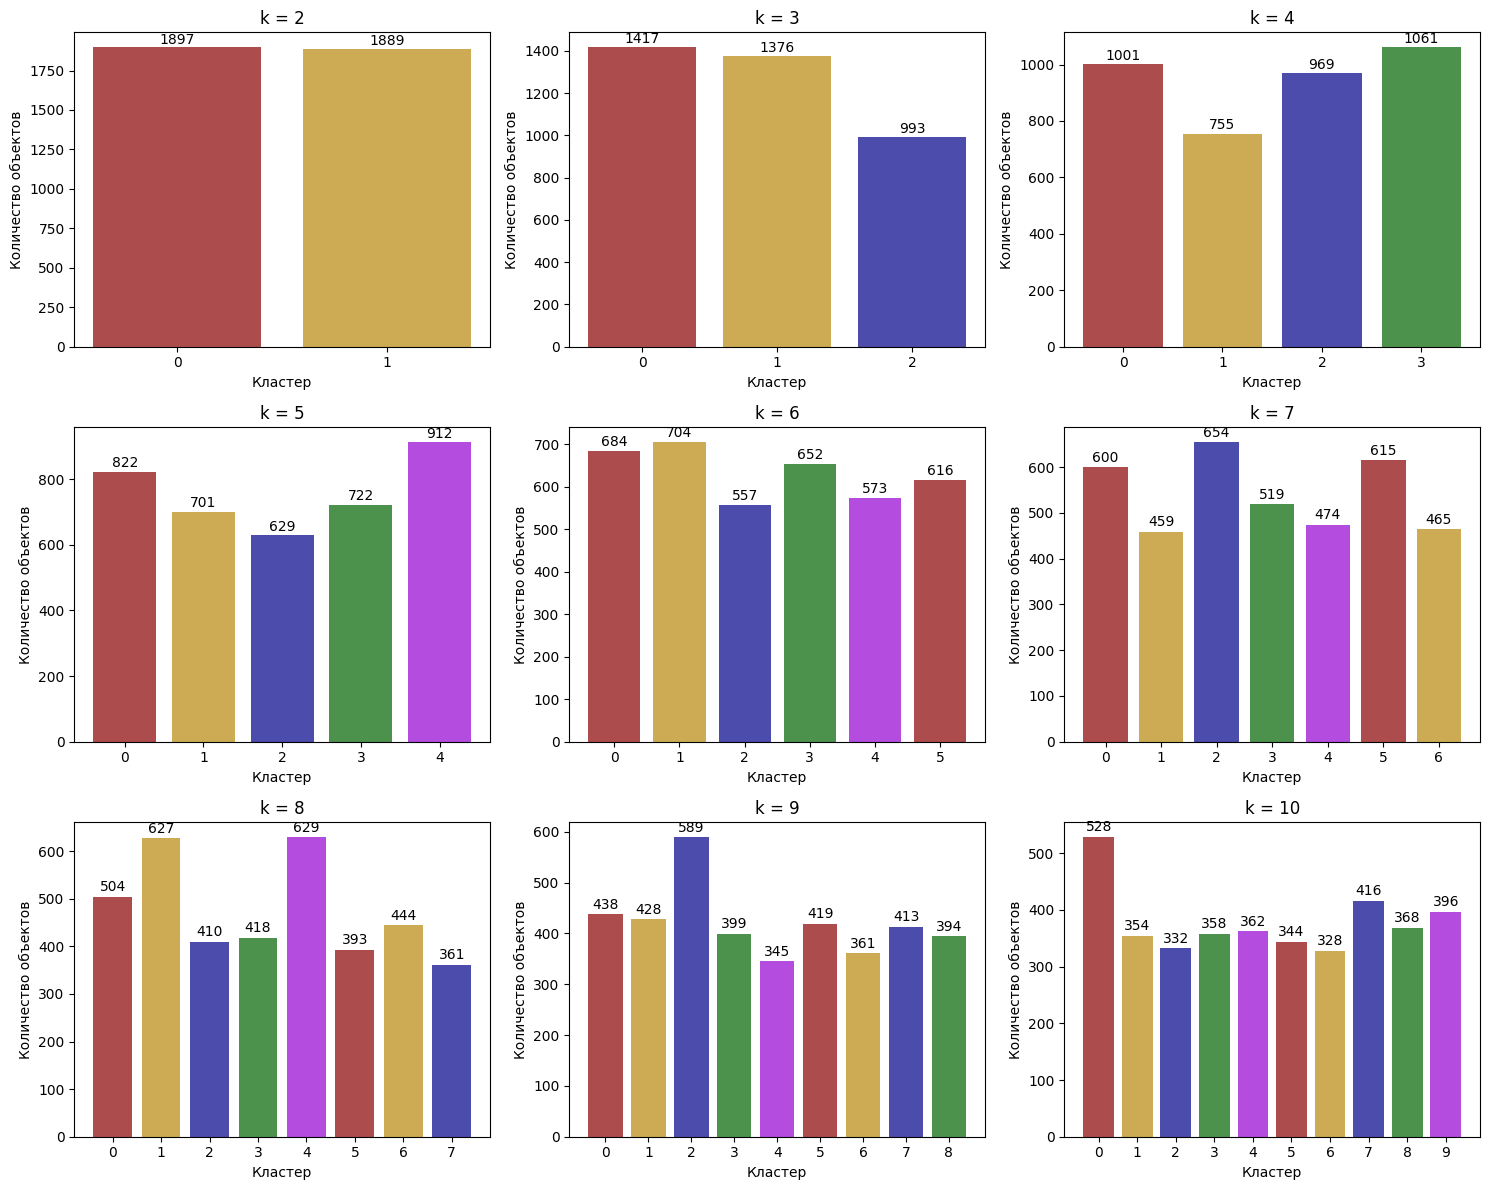

In [457]:
# Визуализация стабильности кластеров
print("\nВизуализация стабильности кластеров")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, k in enumerate(k_range):
    cluster_sizes = results_df.loc[results_df['k'] == k, 'cluster_sizes'].values[0]
    axes[idx].bar(range(len(cluster_sizes)), cluster_sizes, 
                 color=['darkred', 'darkgoldenrod', 'darkblue', 'darkgreen', 'darkviolet'][:len(cluster_sizes)],
                 alpha=0.7)
    axes[idx].set_title(f'k = {k}')
    axes[idx].set_xlabel('Кластер')
    axes[idx].set_ylabel('Количество объектов')
    axes[idx].set_xticks(range(len(cluster_sizes)))

    for i, size in enumerate(cluster_sizes):
        axes[idx].text(i, size + 5, str(size), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [458]:
from sklearn.decomposition import PCA

print("Снижение размерности")

# PCA 2D
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_final)

# PCA 3D
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_final)

# Вывод объясненной дисперсии
explained_2d = pca_2d.explained_variance_ratio_
explained_3d = pca_3d.explained_variance_ratio_

print("Объясненная дисперсия PCA:")
print(f"2D PCA: {explained_2d.sum():.3f} ({explained_2d})")
print(f"3D PCA: {explained_3d.sum():.3f} ({explained_3d})")


Снижение размерности
Объясненная дисперсия PCA:
2D PCA: 0.422 ([0.21546004 0.20700149])
3D PCA: 0.597 ([0.21546004 0.20700149 0.17451808])


Визуализация кластеров K-Means и GMM в 2D пространстве PCA


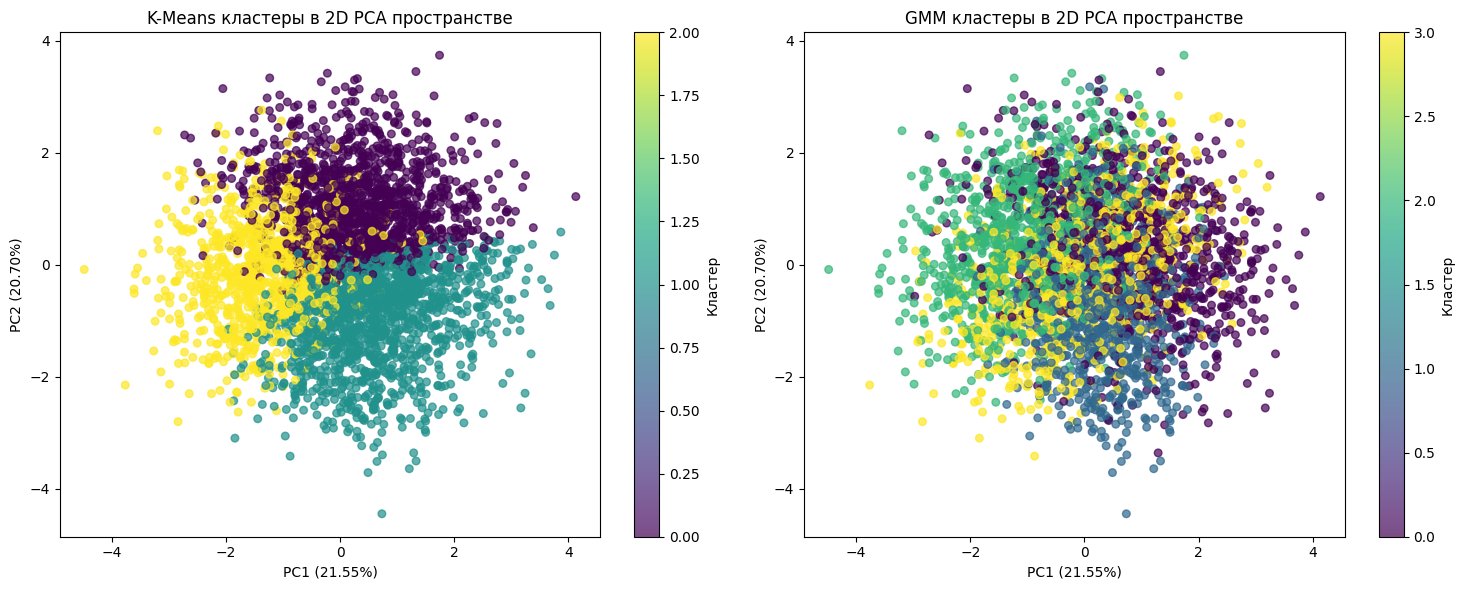

In [459]:
print("Визуализация кластеров K-Means и GMM в 2D пространстве PCA")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# K-Means
scatter_kmeans = axes[0].scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1], 
    c=kmeans_labels, cmap='viridis', alpha=0.7, s=30
)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('K-Means кластеры в 2D PCA пространстве')
plt.colorbar(scatter_kmeans, ax=axes[0], label='Кластер')

# GMM
scatter_gmm = axes[1].scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1], 
    c=gmm_labels, cmap='viridis', alpha=0.7, s=30
)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('GMM кластеры в 2D PCA пространстве')
plt.colorbar(scatter_gmm, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()

По K-means видео границы между 3 кластерами, хоть они и размты, но их видно.
По Gmm нету никаких границ и получается каша из кластеров

Визуализация кластеров в 3D пространстве PCA


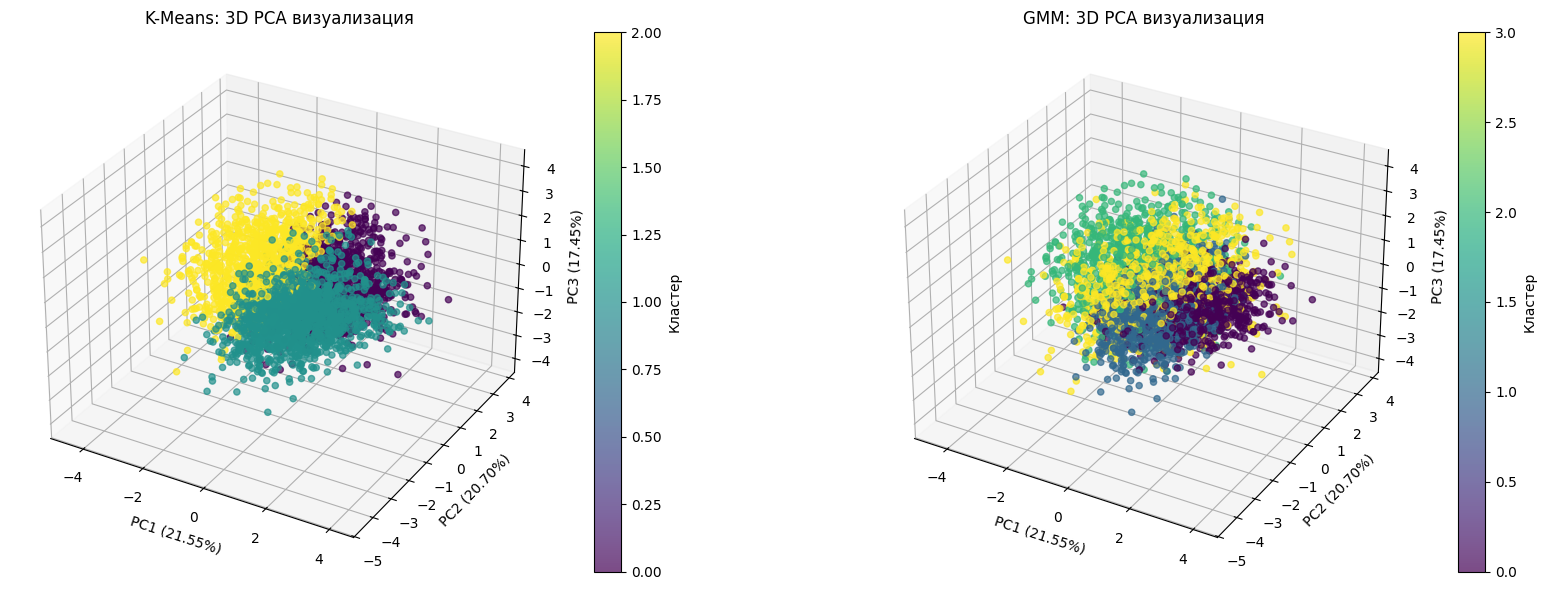

In [460]:
print("Визуализация кластеров в 3D пространстве PCA")

fig = plt.figure(figsize=(18, 6))

# K-Means
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=kmeans_labels, cmap='viridis', alpha=0.7, s=20)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title('K-Means: 3D PCA визуализация')
fig.colorbar(scatter1, ax=ax1, label='Кластер')

# GMM
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=gmm_labels, cmap='viridis', alpha=0.7, s=20)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax2.set_title('GMM: 3D PCA визуализация')
fig.colorbar(scatter2, ax=ax2, label='Кластер')

plt.tight_layout()
plt.show()

In [461]:
print("Анализ центров кластеров K-Means")

# Получаем названия признаков из DataFrame
feature_names = X_final.columns.tolist()

# Центры кластеров (стандартизированные значения)
kmeans_centers = kmeans_final.cluster_centers_
centers_df = pd.DataFrame(kmeans_centers, 
                          columns=feature_names,
                          index=[f'Кластер {i}' for i in range(optimal_k)])
print("Центры кластеров K-Means (стандартизированные значения):")
print(centers_df.round(3))

print("\nКлючевые характеристики кластеров:")
print("(Значения > 0.5 - ВЫСОКИЕ, < -0.5 - НИЗКИЕ)")

for i in range(optimal_k):
    print(f"\nКластер {i}:")
    high_features = []
    low_features = []
    
    for feature_idx, feature_name in enumerate(feature_names):
        value = kmeans_centers[i, feature_idx]
        if value > 0.5:
            high_features.append((feature_name, value))
        elif value < -0.5:
            low_features.append((feature_name, value))
    
    if high_features:
        print("  Высокие показатели:")
        for feature, val in high_features:
            print(f"    - {feature}: {val:.2f}")
    
    if low_features:
        print("  Низкие показатели:")
        for feature, val in low_features:
            print(f"    - {feature}: {val:.2f}")
    
    if not high_features and not low_features:
        print("  Значения признаков в среднем диапазоне")


Анализ центров кластеров K-Means
Центры кластеров K-Means (стандартизированные значения):
            Size  Weight  Sweetness  Crunchiness  Juiciness  Ripeness  Acidity
Кластер 0  0.439   0.056     -0.548        0.523     -0.712     0.138   -0.239
Кластер 1 -0.831  -0.042      0.581       -0.339      0.192     0.400   -0.428
Кластер 2  0.523  -0.023     -0.023       -0.277      0.748    -0.748    0.931

Ключевые характеристики кластеров:
(Значения > 0.5 - ВЫСОКИЕ, < -0.5 - НИЗКИЕ)

Кластер 0:
  Высокие показатели:
    - Crunchiness: 0.52
  Низкие показатели:
    - Sweetness: -0.55
    - Juiciness: -0.71

Кластер 1:
  Высокие показатели:
    - Sweetness: 0.58
  Низкие показатели:
    - Size: -0.83

Кластер 2:
  Высокие показатели:
    - Size: 0.52
    - Juiciness: 0.75
    - Acidity: 0.93
  Низкие показатели:
    - Ripeness: -0.75


In [462]:
print("Анализ центров кластеров K-Means")

# Используем именно X_final — он совпадает по длине с метками
df_with_clusters = X_final.copy()

# Добавляем метки кластеров
df_with_clusters['kmeans_cluster'] = kmeans_final.labels_

# Фактическое число кластеров
n_clusters_actual = kmeans_final.cluster_centers_.shape[0]

# Получаем названия признаков
feature_names = X_final.columns.tolist()

# Центры кластеров
kmeans_centers = kmeans_final.cluster_centers_
centers_df = pd.DataFrame(
    kmeans_centers,
    columns=feature_names,
    index=[f'Кластер {i}' for i in range(n_clusters_actual)]
)

print("Центры кластеров K-Means (стандартизированные значения):")
print(centers_df.round(3))

print("\nКлючевые характеристики кластеров:")
print("(Значения > 0.5 - ВЫСОКИЕ, < -0.5 - НИЗКИЕ)")

for i in range(n_clusters_actual):
    print(f"\nКластер {i}:")
    high_features = []
    low_features = []
    
    for feature_idx, feature_name in enumerate(feature_names):
        value = kmeans_centers[i, feature_idx]
        if value > 0.5:
            high_features.append((feature_name, value))
        elif value < -0.5:
            low_features.append((feature_name, value))
    
    if high_features:
        print("  Высокие показатели:")
        for feature, val in high_features:
            print(f"    - {feature}: {val:.2f}")
    
    if low_features:
        print("  Низкие показатели:")
        for feature, val in low_features:
            print(f"    - {feature}: {val:.2f}")
    
    if not high_features and not low_features:
        print("  Значения признаков в среднем диапазоне")




Анализ центров кластеров K-Means
Центры кластеров K-Means (стандартизированные значения):
            Size  Weight  Sweetness  Crunchiness  Juiciness  Ripeness  Acidity
Кластер 0  0.439   0.056     -0.548        0.523     -0.712     0.138   -0.239
Кластер 1 -0.831  -0.042      0.581       -0.339      0.192     0.400   -0.428
Кластер 2  0.523  -0.023     -0.023       -0.277      0.748    -0.748    0.931

Ключевые характеристики кластеров:
(Значения > 0.5 - ВЫСОКИЕ, < -0.5 - НИЗКИЕ)

Кластер 0:
  Высокие показатели:
    - Crunchiness: 0.52
  Низкие показатели:
    - Sweetness: -0.55
    - Juiciness: -0.71

Кластер 1:
  Высокие показатели:
    - Sweetness: 0.58
  Низкие показатели:
    - Size: -0.83

Кластер 2:
  Высокие показатели:
    - Size: 0.52
    - Juiciness: 0.75
    - Acidity: 0.93
  Низкие показатели:
    - Ripeness: -0.75


Сравнительный анализ K-Means и GMM


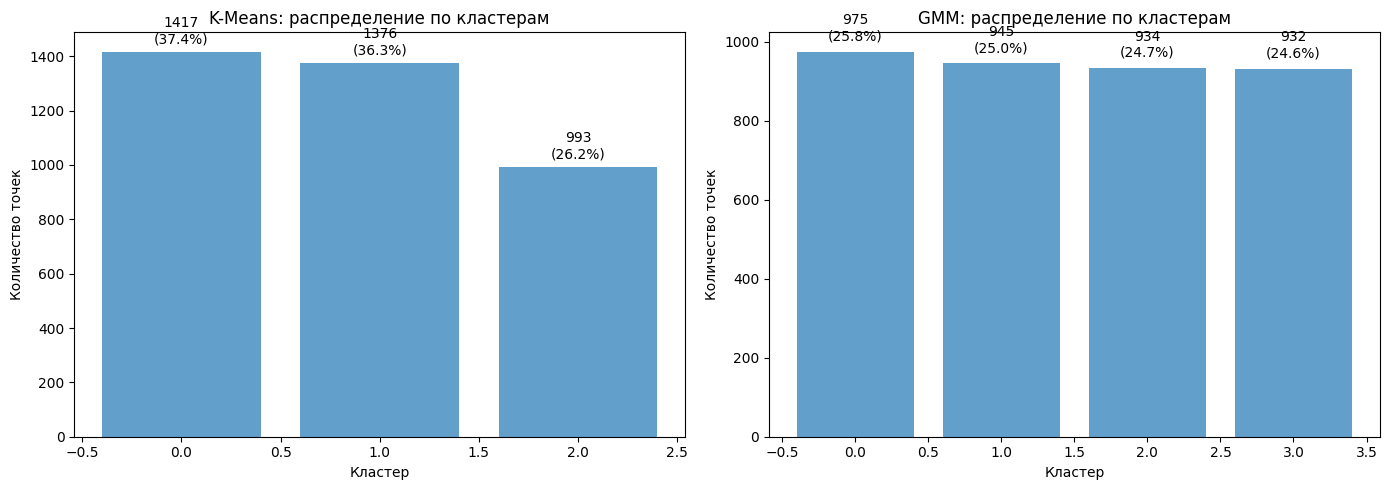

Согласованность кластеризаций (Adjusted Rand Index): 0.171

Матрица сопряженности кластеризаций:
           GMM 0  GMM 1  GMM 2  GMM 3
K-Means 0    564    224    332    297
K-Means 1    378    692     15    291
K-Means 2     33     29    587    344
K-Means 3      0      0      0      0


In [463]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix

print("Сравнительный анализ K-Means и GMM")

# --- ВИЗУАЛИЗАЦИЯ РАСПРЕДЕЛЕНИЯ КЛАСТЕРОВ ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# K-Means распределение
kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index()
axes[0].bar(kmeans_counts.index, kmeans_counts.values, alpha=0.7)
axes[0].set_title('K-Means: распределение по кластерам')
axes[0].set_xlabel('Кластер')
axes[0].set_ylabel('Количество точек')
for i, count in enumerate(kmeans_counts.values):
    axes[0].text(kmeans_counts.index[i], count + 20,
                 f'{count}\n({count/len(kmeans_labels):.1%})',
                 ha='center', va='bottom')

# GMM распределение
gmm_counts = pd.Series(gmm_labels).value_counts().sort_index()
axes[1].bar(gmm_counts.index, gmm_counts.values, alpha=0.7)
axes[1].set_title('GMM: распределение по кластерам')
axes[1].set_xlabel('Кластер')
axes[1].set_ylabel('Количество точек')
for i, count in enumerate(gmm_counts.values):
    axes[1].text(gmm_counts.index[i], count + 20,
                 f'{count}\n({count/len(gmm_labels):.1%})',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

# --- МЕТРИКИ СРАВНЕНИЯ ---
# ARI
ari_score = adjusted_rand_score(kmeans_labels, gmm_labels)
print(f"Согласованность кластеризаций (Adjusted Rand Index): {ari_score:.3f}")

# Матрица сопряжённости
conf_matrix = confusion_matrix(kmeans_labels, gmm_labels)

# Индексы и колонки по уникальным меткам реально в матрице
conf_df = pd.DataFrame(
    conf_matrix,
    index=[f'K-Means {i}' for i in range(conf_matrix.shape[0])],
    columns=[f'GMM {j}' for j in range(conf_matrix.shape[1])]
)

print("\nМатрица сопряженности кластеризаций:")
print(conf_df)



In [464]:
print("\nИтоговый сравнительный анализ")

# --- Сбалансированность кластеров ---
# K-Means
kmeans_cluster_sizes = np.bincount(kmeans_labels)
kmeans_balance = kmeans_cluster_sizes.min() / kmeans_cluster_sizes.max()

# GMM
gmm_cluster_sizes = np.bincount(gmm_labels)
gmm_balance = gmm_cluster_sizes.min() / gmm_cluster_sizes.max()

# Создание таблицы сравнения
comparison_summary = pd.DataFrame({
    'Метод': ['K-Means', 'Gaussian Mixture'],
    'Кластеры': [len(kmeans_cluster_sizes), len(gmm_cluster_sizes)],
    'Сбалансированность': [f"{kmeans_balance:.1%}", f"{gmm_balance:.1%}"],
    'Silhouette': [sil_score_kmeans, sil_score_gmm],
    'Calinski-Harabasz': [ch_score_kmeans, ch_score_gmm],
    'Davies-Bouldin': [davies_bouldin_score(X_final, kmeans_labels),
                        davies_bouldin_score(X_final, gmm_labels)],
    'Интерпретируемость': ['ВЫСОКАЯ', 'НИЗКАЯ'],
    'Стабильность': ['ВЫСОКАЯ', 'НИЗКАЯ'],
    'Рекомендация': ['++ РЕКОМЕНДУЕТСЯ', '- НЕ РЕКОМЕНДУЕТСЯ']
})

print(comparison_summary)



Итоговый сравнительный анализ
              Метод  Кластеры Сбалансированность  Silhouette  \
0           K-Means         3              70.1%    0.139795   
1  Gaussian Mixture         4              95.6%    0.049473   

   Calinski-Harabasz  Davies-Bouldin Интерпретируемость Стабильность  \
0         594.495635        2.008525            ВЫСОКАЯ      ВЫСОКАЯ   
1         233.214183        3.185544             НИЗКАЯ       НИЗКАЯ   

         Рекомендация  
0    ++ РЕКОМЕНДУЕТСЯ  
1  - НЕ РЕКОМЕНДУЕТСЯ  
